# BUSINESS CONTEXT: E-Commerce Customer Response Time Analysis

![routing_pic](routing_pic.png)
You are a data analyst at "FastShip", an e-commerce logistics company. 
The company recently implemented a new routing system (Group B) 
and wants to compare it against the traditional routing system (Group A).

The metric being measured: Customer delivery time (in days) from order placement.

WHY THIS MATTERS:
- Delivery times follow an exponential distribution (most deliveries are fast, but some take much longer due to various complications).
- The company needs to decide whether to roll out the new system company-wide
- This decision affects millions of dollars in operational costs and customer satisfaction
- Traditional statistical tests assume normal distributions, which don't apply here

YOUR MISSION:
Use bootstrapping and permutation testing to determine if the new routing 
system (Group B) actually performs differently from the traditional system (Group A).
The company needs robust statistical evidence before making this expensive transition.

 YOUR TASKS:
 1. Implement bootstrap confidence intervals (95%) for the difference in means
    - Use at least 10,000 bootstrap samples
    - Calculate the confidence interval using the percentile method

 2. Implement a permutation test to test if the two groups have different means
    - Null hypothesis: The two groups come from the same distribution
    - Use at least 10,000 permutations
    - Calculate the p-value

 3. Compare your results with a standard t-test and a nonparametric test

 4. BONUS: Repeat the analysis using the median instead of the mean as the test statistic

In [1]:
# data generation
import numpy as np

# Generate synthetic data with a nonlinear relationship
np.random.seed(42)
n = 100

# Group A: Exponential-like distribution
group_a = np.random.exponential(scale=2.2, size=n)+np.random.random(size=n)/100

# Group B: Exponential distribution with different parameter
group_b = np.random.exponential(scale=2.6, size=n)+np.random.random(size=n)/100


       group_a  group_b
count  100.000  100.000
mean     2.017    2.676
std      2.024    2.423
min      0.017    0.021
25%      0.479    0.852
50%      1.375    2.157
75%      2.889    3.635
max      9.541   11.994


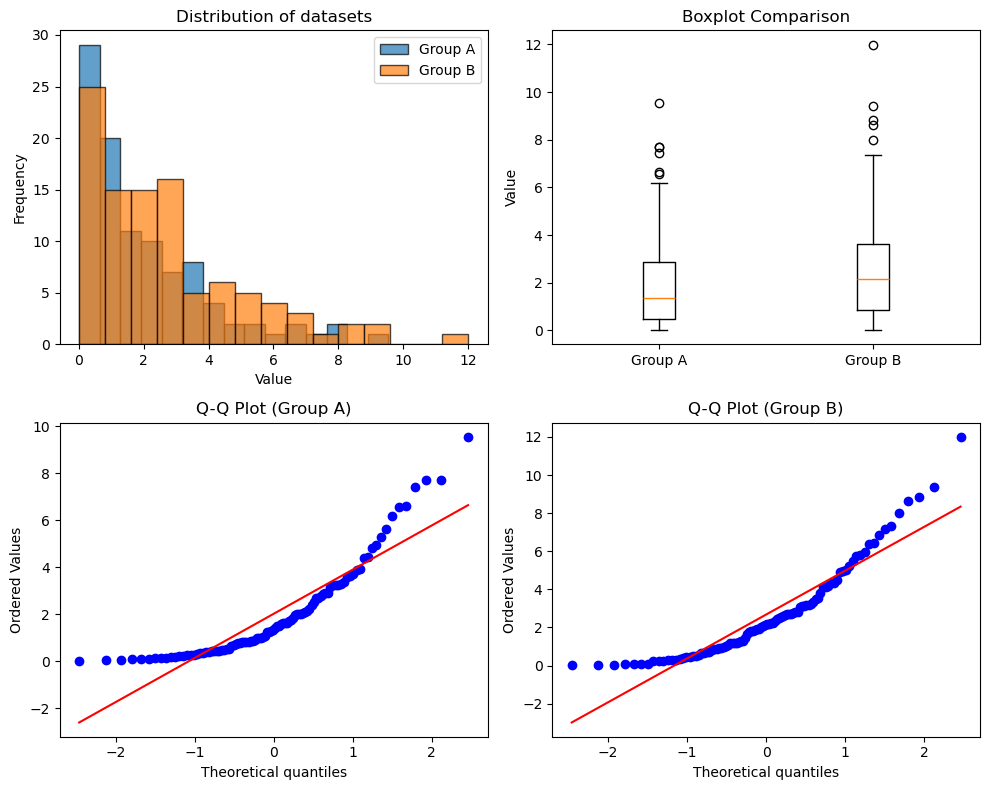

In [2]:
# visualize the data
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

pd.set_option('float_format', '{:f}'.format)
pd.options.display.float_format = "{:.3f}".format

df = pd.DataFrame({
    'group_a':group_a,
    'group_b':group_b
})
print('='*50)
print(df.describe())
print('='*50)

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.hist(df['group_a'], bins=15, alpha=0.7, label='Group A', edgecolor='black')
plt.hist(df['group_b'], bins=15, alpha=0.7, label='Group B', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of datasets')

plt.subplot(2, 2, 2)
plt.boxplot(df, tick_labels=['Group A', 'Group B'])
plt.ylabel('Value')
plt.title('Boxplot Comparison')

plt.subplot(2, 2, 3)
stats.probplot(df['group_a'], dist="norm", plot=plt)
plt.title('Q-Q Plot (Group A)')

plt.subplot(2, 2, 4)
stats.probplot(df['group_b'], dist="norm", plot=plt)
plt.title('Q-Q Plot (Group B)')

plt.tight_layout()
plt.show()

In [3]:
# task 1
def bootstrap_func(df, alpha = 0.05, num_samples = 10000, metric = 'mean'):
    """
    calculates the bootstrap confidence interval
    for means/medians for a given alpha level.
    Args:
        df (DataFrame): data that contains 'group_a' and 'group_b'
        alpha (float): the alpha for calculation of confidence intervals
        num_samples (int): number of samples for bootstrapping
    Returns:
        DataFrame: containing mean, std, ci_upper, and ci_lower of 
        mean/median of differences between groups
    Raises:
        TypeError: if num_samples is not an int or alpha is not a float
        ValueError: if alpha is not between 0 and 1
        ValueError: if df does not contain group_a and group_b
        ValueError: if metric is not either mean or median
    """
    if not isinstance(num_samples,int):
        raise TypeError('num_samples should be int')
    elif not isinstance(alpha,float):
        raise TypeError('alpha should be float')
    elif not (alpha >0 and alpha <1):
        raise ValueError('alpha should be between 0 and 1')
    elif not all(col in df.columns for col in ['group_a', 'group_b']):
        raise ValueError("df should contain 'Group_a' and 'Group_b'")
    elif not (metric for metric in ['mean', 'median']):
        raise ValueError('metric should be either "mean" or "median"')
        
    diff=[]
    for _ in range(num_samples):
        subsample_a = pd.Series(df['group_a'].sample(frac= 1, replace=True))
        subsample_b = pd.Series(df['group_b'].sample(frac= 1, replace=True))
        if metric=='mean':
            diff.append(subsample_a.mean()-subsample_b.mean())
        elif metric=='median':
            diff.append(subsample_a.median()- subsample_b.median())
        
        
    diff = pd.Series(diff)
    
    result = diff.agg([
        lambda x: x.mean(),
        lambda x: x.std(),
        lambda x: x.quantile(alpha/2),
        lambda x: x.quantile(1-alpha/2)
    ])
    result.index = ['mean','std','ci_lower','ci_upper']
    
    
    print(f"""the mean difference between bootstrapped {metric}s of two methods:\n
    mean[ci_lower, ci_upper] ± std
    {result.loc['mean']:.3f}[{result.loc['ci_lower']:.3f},{result.loc['ci_upper']:.3f}] ± {result.loc['std']:.3f}""")

    return result

print('='*80)
print('Task 1 results')
print('='*80)
bootstrap_func(df, metric='mean')
print('='*80)

Task 1 results
the mean difference between bootstrapped means of two methods:

    mean[ci_lower, ci_upper] ± std
    -0.659[-1.270,-0.047] ± 0.312


Task 2 results
Observed difference in mean: -0.659
P-value: 0.0387
Result: STATISTICALLY SIGNIFICANT (p < 0.05)


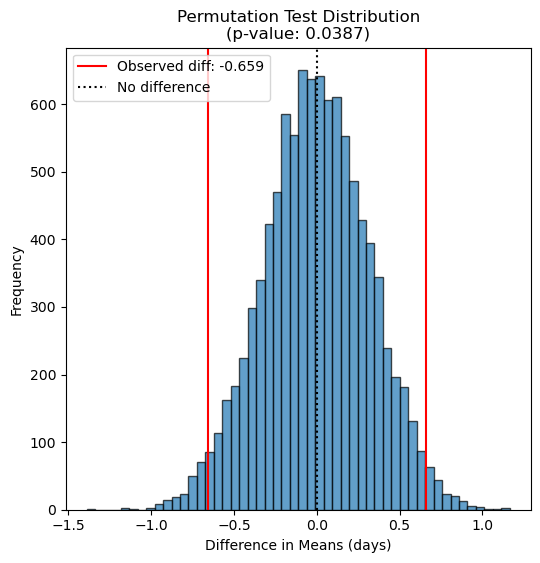

In [4]:
# task 2
def permutation_test(df, alpha = 0.05, num_samples = 10000, metric = 'mean'):
    """
    calculates the permutation test
    for means/medians for a given alpha level.
    Args:
        df (DataFrame): data that contains 'group_a' and 'group_b'
        alpha (float): the alpha for inference
        num_samples (int): number of permutations
    Returns:
        DataFrame: containing mean, std, ci_upper, and ci_lower of 
        mean/median of differences between groups
    Raises:
        TypeError: if num_samples is not an int or alpha is not a float
        ValueError: if alpha is not between 0 and 1
        ValueError: if df does not contain group_a and group_b
        ValueError: if metric is not either mean or median
    """
    if not isinstance(num_samples,int):
        raise TypeError('num_samples should be int')
    elif not isinstance(alpha,float):
        raise TypeError('alpha should be float')
    elif not (alpha >0 and alpha <1):
        raise ValueError('alpha should be between 0 and 1')
    elif not all(col in df.columns for col in ['group_a', 'group_b']):
        raise ValueError("df should contain 'Group_a' and 'Group_b'")
    elif not (metric for metric in ['mean', 'median']):
        raise ValueError('metric should be either "mean" or "median"')
        
    flat_df = df.values.flatten()
    len_df = df.shape[0]

    diff=[]
    for _ in range(num_samples):
        df_permute = np.random.permutation(flat_df).reshape([2,len_df])
        if metric == 'mean':
            diff.append(np.mean(df_permute[0,:]) - np.mean(df_permute[1,:]))
        elif metric == 'median':
            diff.append(np.median(df_permute[0,:])-np.median(df_permute[1,:]))
        
    diff = pd.Series(diff)
    
    if metric == 'mean':
        actual_diff = df['group_a'].mean() - df['group_b'].mean()
    elif metric == 'median':
        actual_diff = df['group_a'].median() - df['group_b'].median()

    result = (np.abs(diff) >= np.abs(actual_diff)).sum()/num_samples

    print(f"Observed difference in {metric}: {actual_diff:.3f}")
    print(f"P-value: {result:.4f}")

    if result < 0.05:
        print("Result: STATISTICALLY SIGNIFICANT (p < 0.05)")
    else:
        print("Result: NOT STATISTICALLY SIGNIFICANT (p >= 0.05)")
    
    return {
        'observed_diff': actual_diff,
        'permuted_diffs': diff,
        'p_value': result
    }

print('='*80)
print('Task 2 results')
print('='*80)
mean_result = permutation_test(df, metric='mean')
print('='*80)

# visualization of results
plt.figure(figsize=[6,6])

plt.hist(mean_result['permuted_diffs'], bins = 50, edgecolor='black', alpha = .7)
plt.axvline(mean_result['observed_diff'], 
            color='red', 
            linestyle='-', 
            label=f'Observed diff: {mean_result["observed_diff"]:.3f}')
plt.axvline(-mean_result['observed_diff'], 
            color='red', 
            linestyle='-')
plt.axvline(0, color='black', linestyle=':', label='No difference')
plt.xlabel('Difference in Means (days)')
plt.ylabel('Frequency')
plt.title(f'Permutation Test Distribution\n(p-value: {mean_result["p_value"]:.4f})')
plt.legend()
plt.show()

In [5]:
# task 3
print('='*80)
print('Task 3: t-test results')
t_val, p_val = stats.ttest_ind(df['group_a'], df['group_b'], alternative='two-sided')
print(f"the t-test results: t({df.shape[0]*2-2})={t_val:.3f}, p={p_val:.3f}")
print('='*80)
print('\n')

print('='*80)
print('Task 3: Mann-Whitney U results')
u_val, p_val = stats.mannwhitneyu(df['group_a'], df['group_b'], alternative='two-sided')
print(f"the MWU results: U({df.shape[0]},{df.shape[0]})={u_val:.3f}, p={p_val:.3f}")
print('='*80)

Task 3: t-test results
the t-test results: t(198)=-2.087, p=0.038


Task 3: Mann-Whitney U results
the MWU results: U(100,100)=4154.000, p=0.039


Task 4: Bootstrapping results for mean
the mean difference between bootstrapped medians of two methods:

    mean[ci_lower, ci_upper] ± std
    -0.760[-1.450,-0.041] ± 0.360


Task 4: permutation results for median
Observed difference in median: -0.782
P-value: 0.0438
Result: STATISTICALLY SIGNIFICANT (p < 0.05)




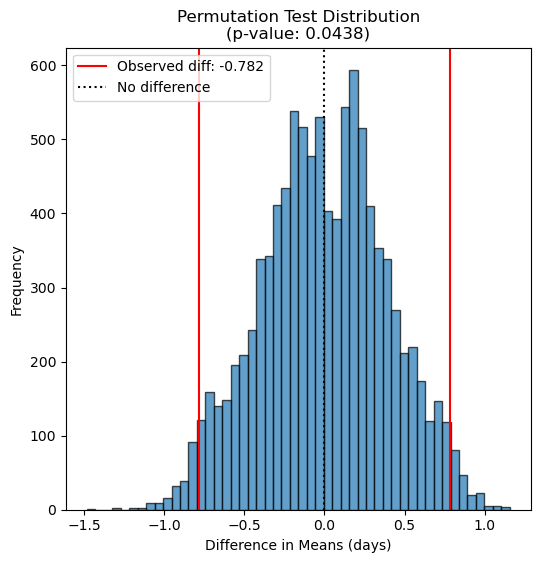

In [6]:
# task 4 
print('='*80)
print('Task 4: Bootstrapping results for mean')
print('='*80)
bootstrap_func(df, metric='median')
print('='*80)
print('\n')

print('='*80)
print('Task 4: permutation results for median')
print('='*80)
median_result = permutation_test(df, metric='median')
print('='*80)
print('\n')

# visualization of results
plt.figure(figsize=[6,6])

plt.hist(median_result['permuted_diffs'], bins = 50, edgecolor='black', alpha = .7)
plt.axvline(median_result['observed_diff'], 
            color='red', 
            linestyle='-', 
            label=f'Observed diff: {median_result["observed_diff"]:.3f}')
plt.axvline(-median_result['observed_diff'], 
            color='red', 
            linestyle='-')
plt.axvline(0, color='black', linestyle=':', label='No difference')
plt.xlabel('Difference in Means (days)')
plt.ylabel('Frequency')
plt.title(f'Permutation Test Distribution\n(p-value: {median_result["p_value"]:.4f})')
plt.legend()
plt.show()